<a href="https://colab.research.google.com/github/J-DR1/MastersThesis/blob/main/2_Fraud_models_experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

---



In [ ]:
#Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Pyod
try:
  import pyod
except:
  !pip install pyod
finally:
  import pyod
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.utils.data import evaluate_print

#Isotree
try:
  import isotree
except: 
  !pip install isotree
finally:
  from isotree import IsolationForest

#Machine Learning - Sci-kit Learn

##Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import preprocessing

##Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

##Hyper Parameter Tuning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV

#Warnings
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Functions 

---



In [ ]:
#Functions 
#Train-test splits
def train_test_split(full_dataframe, train_size, test_size):
    train_set = full_dataframe.iloc[:200000].sample(random_state = 42, n = train_size)
    train_X = train_set.drop('Class', axis = 1) 
    train_y = train_set['Class']
    
    test_set = full_dataframe.iloc[-70000:].sample(random_state = 42, n = test_size)
    test_X = test_set.drop('Class', axis = 1)
    test_y = test_set['Class']
    return train_X, test_X, train_y, test_y

#Prints true contamination rate
def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)

#Fitting and predictions     
def get_prediction(classifier, train_X, test_X, train_y, test_y, model_name =''):
  
    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)

    #Evaluate using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, train_y, clf.decision_scores_) #raw outlier scores
    print("\nOn Test Data:")
    evaluate_print(model_name, test_y, clf.decision_function(test_X)) #decision_function(X_test): outlier scores for predicted test data

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, pred, target_names=['Normal', 'Anomaly'] ))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
    print("\n", model_name, "f1-score", f1_score(test_y, pred))

    #Plots confusion matrix
    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Anomaly','Predicted Normal'],
                yticklabels = ['Actual Anomaly','Actual Normal'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    #Plots ROC Curve
    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

#Functions for iso-tree package (same steps as above)
def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, model_name =''):

    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    
    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, temp_pred))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, temp_pred))
    print("\n", model_name, "f1-score", f1_score(test_y, temp_pred))

    plt.figure()
    sns.heatmap(data = confusion_matrix(test_y, temp_pred),
                xticklabels = ['Predicted Anomaly','Predicted Normal'],
                yticklabels = ['Actual Anomaly','Actual Normal'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)

    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


# Import & Standardization of Fraud

---



In [ ]:
fraud = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditcard.csv")
fraud.head(5) 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Train-Test Split & Standardization

---



In [ ]:
train_X, test_X, train_y, test_y = train_test_split(fraud, 200000, 70000)

In [ ]:
scaler = RobustScaler()

train_X['Amount'] = scaler.fit_transform(train_X['Amount'].values.reshape(-1, 1))
train_X['Time'] = scaler.fit_transform(train_X['Time'].values.reshape(-1, 1))

test_X['Amount'] = scaler.transform(test_X['Amount'].values.reshape(-1, 1))
test_X['Time'] = scaler.transform(test_X['Time'].values.reshape(-1, 1))


In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

#IForest

---



On Training Data:
IForest ROC:0.951, precision @ rank n:0.3377

On Test Data:
IForest ROC:0.9433, precision @ rank n:0.0109

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.94      0.97     69908
     Anomaly       0.02      0.83      0.04        92

    accuracy                           0.94     70000
   macro avg       0.51      0.89      0.50     70000
weighted avg       1.00      0.94      0.97     70000


 IForest  Confusion Matrix: 
 [[66005  3903]
 [   16    76]]

 IForest Matthews Correlation Coefficient 0.12052153930158016

 IForest f1-score 0.03733726357160403


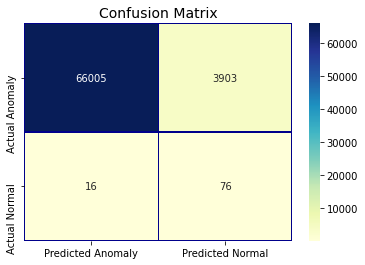

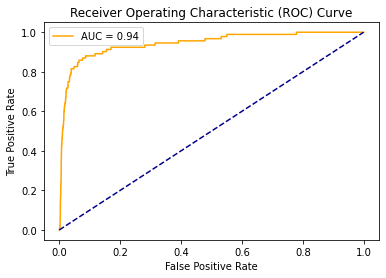

In [ ]:
#Not Standardized - 0.05
get_prediction(IForest(n_estimators = 100, max_samples = 128, contamination = 0.05, random_state=42), 
               train_X, test_X, train_y, test_y, 'IForest')

On Training Data:
IForest ROC:0.951, precision @ rank n:0.3377

On Test Data:
IForest ROC:0.9433, precision @ rank n:0.0109

 IForest  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     69908
     Anomaly       0.04      0.66      0.08        92

    accuracy                           0.98     70000
   macro avg       0.52      0.82      0.53     70000
weighted avg       1.00      0.98      0.99     70000


 IForest  Confusion Matrix: 
 [[68449  1459]
 [   31    61]]

 IForest Matthews Correlation Coefficient 0.1596268170920668

 IForest f1-score 0.07568238213399504


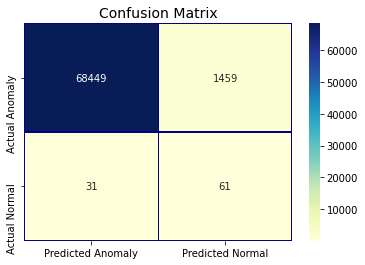

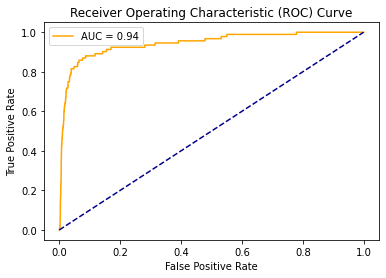

In [ ]:
#Not Standardized - 0.02
get_prediction(IForest(n_estimators = 100, max_samples = 128, contamination = 0.02, random_state=42), 
               train_X, test_X, train_y, test_y, 'IForest')

#OCSVM

---



On Training Data:
OCSVM ROC:0.953, precision @ rank n:0.1091

On Test Data:
OCSVM ROC:0.9494, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     69908
     Anomaly       0.03      0.83      0.05        92

    accuracy                           0.96     70000
   macro avg       0.51      0.89      0.52     70000
weighted avg       1.00      0.96      0.98     70000


 OCSVM  Confusion Matrix: 
 [[67281  2627]
 [   16    76]]

 OCSVM Matthews Correlation Coefficient 0.14826653233850987

 OCSVM f1-score 0.05438282647584974


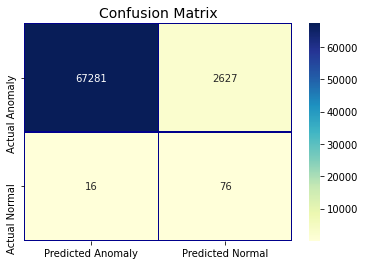

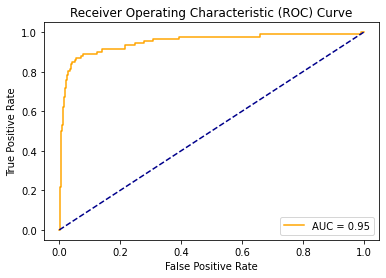

In [ ]:
#Standardized - 0.05
get_prediction(OCSVM(gamma = 'scale', contamination= 0.05, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

On Training Data:
OCSVM ROC:0.953, precision @ rank n:0.1091

On Test Data:
OCSVM ROC:0.9494, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     69908
     Anomaly       0.08      0.47      0.14        92

    accuracy                           0.99     70000
   macro avg       0.54      0.73      0.57     70000
weighted avg       1.00      0.99      1.00     70000


 OCSVM  Confusion Matrix: 
 [[69432   476]
 [   49    43]]

 OCSVM Matthews Correlation Coefficient 0.1945126899388097

 OCSVM f1-score 0.1407528641571195


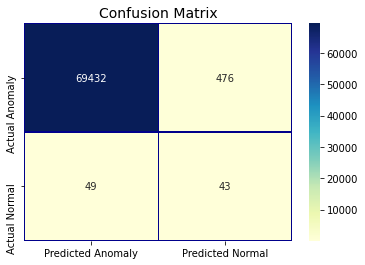

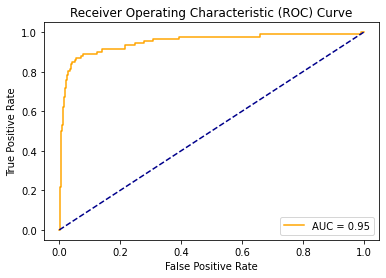

In [ ]:
#Standardized - 0.01
get_prediction(OCSVM(gamma = 'scale', contamination= 0.01, kernel = 'rbf'),
               train_X, test_X, train_y, test_y, 'OCSVM')

#LOF

---



On Training Data:
LOF ROC:0.9606, precision @ rank n:0.5948

On Test Data:
LOF ROC:0.9288, precision @ rank n:0.0109

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.82      0.90     69908
     Anomaly       0.01      0.89      0.01        92

    accuracy                           0.82     70000
   macro avg       0.50      0.85      0.46     70000
weighted avg       1.00      0.82      0.90     70000


 LOF  Confusion Matrix: 
 [[57036 12872]
 [   10    82]]

 LOF Matthews Correlation Coefficient 0.06597368033442629

 LOF f1-score 0.012570902958761307


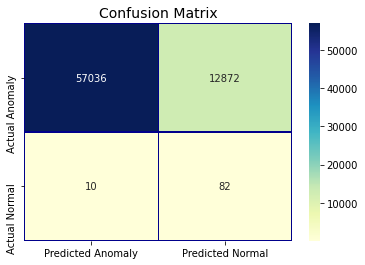

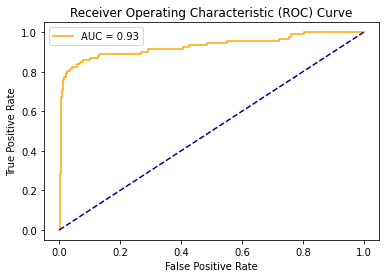

In [ ]:
#Standardized - n_neighbors =  500 - 0.05
get_prediction(LOF(n_neighbors=500, contamination= 0.05, algorithm='auto'), 
               train_X, test_X, train_y, test_y, 'LOF')

On Training Data:
LOF ROC:0.9606, precision @ rank n:0.5948

On Test Data:
LOF ROC:0.9288, precision @ rank n:0.0109

 LOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     69908
     Anomaly       0.02      0.83      0.04        92

    accuracy                           0.95     70000
   macro avg       0.51      0.89      0.51     70000
weighted avg       1.00      0.95      0.97     70000


 LOF  Confusion Matrix: 
 [[66513  3395]
 [   16    76]]

 LOF Matthews Correlation Coefficient 0.12975911209250596

 LOF f1-score 0.04266067920291889


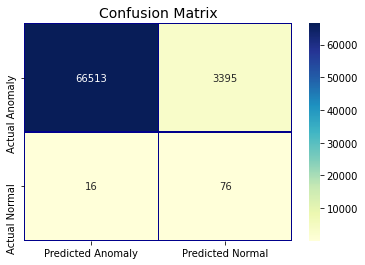

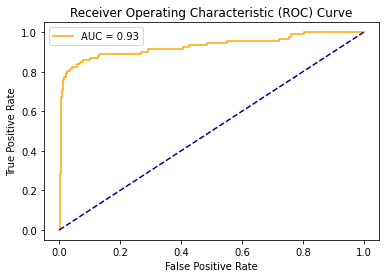

In [ ]:
#Standardized - n_neighbors- 500-  0.01 
get_prediction(LOF(n_neighbors=500, contamination= 0.01, algorithm='auto'), 
               train_X, test_X, train_y, test_y, 'LOF')

#CBLOF

---



On Training Data:
CBLOF ROC:0.9553, precision @ rank n:0.2935

On Test Data:
CBLOF ROC:0.9559, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     69908
     Anomaly       0.02      0.85      0.04        92

    accuracy                           0.95     70000
   macro avg       0.51      0.90      0.51     70000
weighted avg       1.00      0.95      0.97     70000


 CBLOF  Confusion Matrix: 
 [[66483  3425]
 [   14    78]]

 CBLOF Matthews Correlation Coefficient 0.13273709927577726

 CBLOF f1-score 0.04339360222531293


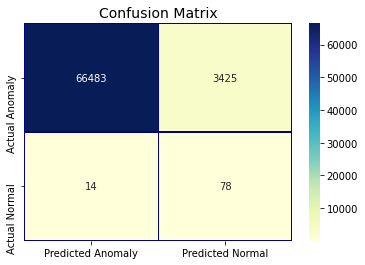

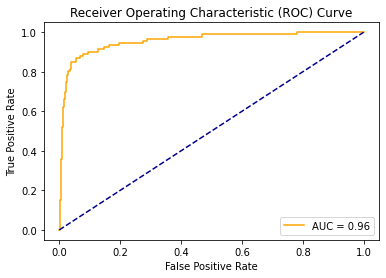

In [ ]:
#Standardized - 0.05
get_prediction(CBLOF(contamination= 0.05, n_clusters= 15, alpha= 0.9, beta= 15, use_weights=False, random_state= 42), 
               train_X, test_X, train_y, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.9553, precision @ rank n:0.2935

On Test Data:
CBLOF ROC:0.9559, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     69908
     Anomaly       0.05      0.62      0.09        92

    accuracy                           0.98     70000
   macro avg       0.53      0.80      0.54     70000
weighted avg       1.00      0.98      0.99     70000


 CBLOF  Confusion Matrix: 
 [[68853  1055]
 [   35    57]]

 CBLOF Matthews Correlation Coefficient 0.17515025081197458

 CBLOF f1-score 0.09468438538205981


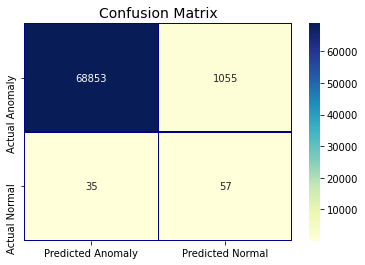

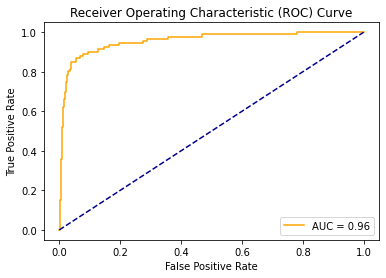

In [ ]:
#Standardized - 0.02
get_prediction(CBLOF(contamination= 0.02, n_clusters= 15, alpha= 0.9, beta= 15, use_weights=False, random_state= 42), 
               train_X, test_X, train_y, test_y, 'CBLOF')

On Training Data:
CBLOF ROC:0.9553, precision @ rank n:0.2935

On Test Data:
CBLOF ROC:0.9559, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     69908
     Anomaly       0.06      0.27      0.09        92

    accuracy                           0.99     70000
   macro avg       0.53      0.63      0.54     70000
weighted avg       1.00      0.99      1.00     70000


 CBLOF  Confusion Matrix: 
 [[69487   421]
 [   67    25]]

 CBLOF Matthews Correlation Coefficient 0.12098961462736998

 CBLOF f1-score 0.09293680297397769


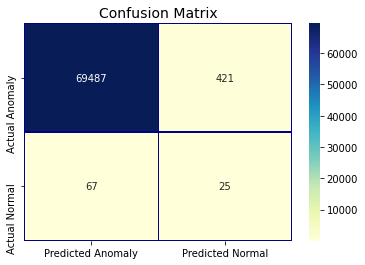

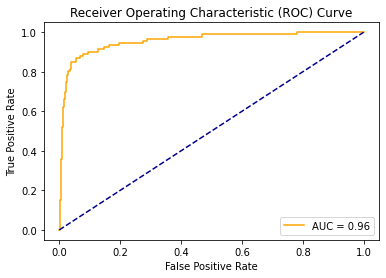

In [ ]:
#Standardized - 0.01
get_prediction(CBLOF(contamination= 0.01, n_clusters= 15, alpha= 0.9, beta= 15, use_weights=False, random_state= 42), 
               train_X, test_X, train_y, test_y, 'CBLOF')

#KNN

---



On Training Data:
KNN ROC:0.9589, precision @ rank n:0.2961

On Test Data:
KNN ROC:0.9446, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     69908
     Anomaly       0.08      0.59      0.15        92

    accuracy                           0.99     70000
   macro avg       0.54      0.79      0.57     70000
weighted avg       1.00      0.99      0.99     70000


 KNN  Confusion Matrix: 
 [[69319   589]
 [   38    54]]

 KNN Matthews Correlation Coefficient 0.2197017283381857

 KNN f1-score 0.14693877551020407


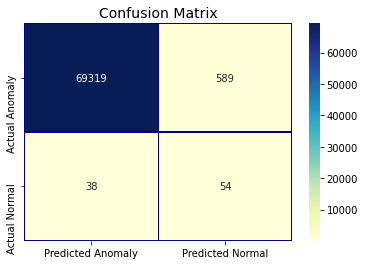

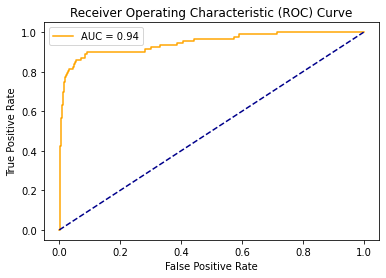

In [ ]:
#Standardized - 0.05
get_prediction(KNN(n_neighbors= 500, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

On Training Data:
KNN ROC:0.9589, precision @ rank n:0.2961

On Test Data:
KNN ROC:0.9446, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     69908
     Anomaly       0.08      0.59      0.15        92

    accuracy                           0.99     70000
   macro avg       0.54      0.79      0.57     70000
weighted avg       1.00      0.99      0.99     70000


 KNN  Confusion Matrix: 
 [[69319   589]
 [   38    54]]

 KNN Matthews Correlation Coefficient 0.2197017283381857

 KNN f1-score 0.14693877551020407


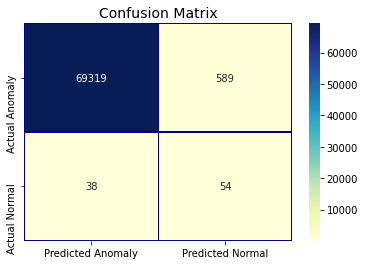

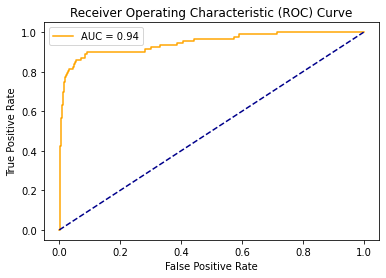

In [ ]:
#Standardized - 0.01
get_prediction(KNN(n_neighbors= 500, method= 'largest', algorithm='auto',contamination= 0.01), 
               train_X, test_X, train_y, test_y, 'KNN')

#IForest-Isotree

---




 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     69908
           1       0.02      0.80      0.05        92

    accuracy                           0.96     70000
   macro avg       0.51      0.88      0.51     70000
weighted avg       1.00      0.96      0.98     70000


 IForest  Confusion Matrix: 
 [[66786  3122]
 [   18    74]]

 IForest Matthews Correlation Coefficient 0.13185258444884074

 IForest f1-score 0.04501216545012166


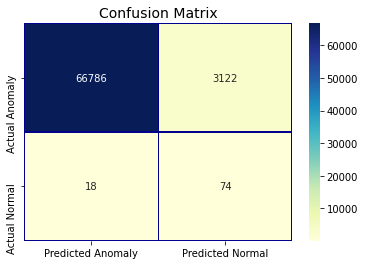

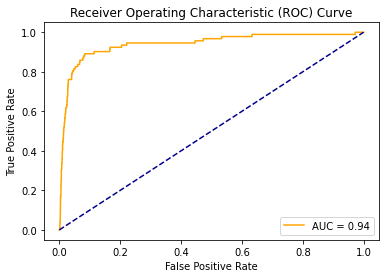

In [ ]:
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'IForest')

#SciForest-Isotree

---




 SciForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     69908
           1       0.01      0.22      0.02        92

    accuracy                           0.97     70000
   macro avg       0.50      0.60      0.50     70000
weighted avg       1.00      0.97      0.99     70000


 SciForest  Confusion Matrix: 
 [[68107  1801]
 [   72    20]]

 SciForest Matthews Correlation Coefficient 0.04361521454599753

 SciForest f1-score 0.020909566126502875


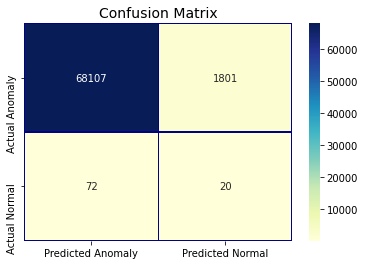

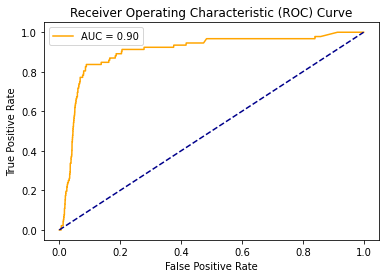

In [ ]:
#Not Standardized
get_prediction_iso(IsolationForest(sample_size = 128 , ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), 
                   train_X, test_X, train_y, test_y, 'SciForest')